<a href="https://colab.research.google.com/github/BlessedMut/AI/blob/master/Data_Masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install cape-privacy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cape Python: 
## Apply Privacy-Enhancing Techniques to Protect Sensitive Data in Pandas and Spark

<p>Cape Python offers several masking techniques to help you obfuscate sensitive data involved in internal data science and machine learning projects. We consider these techniques to be a first step in your privacy journey. We tried to make them as simple as possible so you can quickly start experimenting and thinking about how to make your projects more privacy-preserving. We built this library with the following objectives in mind:</p>

- __Accessible__: these techniques should be very easy to understand and apply at scale with popular data science libraries, such as Pandas and Spark.

- __Collaborative__: data science, machine learning, governance and security teams should be able to collaborate effectively to define and edit data privacy policy through human-readable policy files.

- __Transparent__: At any point, it should be possible to validate which privacy techniques have been applied to which dataset for which task.

## What are Cape Python’s masking techniques?

Cape Python offers several masking techniques to obfuscate identifiers [(de-identification process)](https://en.wikipedia.org/wiki/De-identification#:~:text=De-identification%20is%20the%20process,the%20privacy%20of%20research%20participants.) and sensitive information, included in the dataset. The appropriate method to use depends on the data type (string, numeric, date, etc.), the accuracy you need to maintain, and the type of identifiers:

- __Direct identifiers__: information that relates specifically to an individual. For example: name, address, social security number, etc.
- __Indirect identifiers / quasi identifiers__: Information that can be combined with other information to potentially identify a specific individual. For example: city, zip code, income, etc. As a concrete example, [Latanya Sweeney’s work](http://latanyasweeney.org/work/identifiability.html) demonstrated that “87% of the U.S. population are uniquely identified by date of birth, gender and zip code”.

As an example, we will experiment with the public [German credit card dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). We just added some fake PII information (such as name, address, etc.) and quasi-identifiers to make it more similar to a real dataset for which we would use these techniques.

##### Link to dataset : [download from here](https://data.world/sparklesquad/crm-dataset)

We won’t know for e.g. the city name, however, we can still assess the predictive power of this variable if it is included in the model.


In [3]:
import pandas as pd

from cape_privacy.pandas import dtypes
from cape_privacy.pandas import transformations as tfms
from cape_privacy.pandas.transformations import Tokenizer, DatePerturbation, NumericRounding, ColumnRedact

df = pd.read_csv('/content/drive/MyDrive/Utande/data/sales-pipeline.csv')

In [4]:
tokenize_strings = Tokenizer(max_token_len=10)
perturb_date = DatePerturbation(frequency=("DAY"), min=(-3), max=(3))
round_close_value = NumericRounding(dtype=dtypes.Float, precision=-3)
redact_product_deal = ColumnRedact(columns=["Deal_Stage"])

In [5]:
df.dropna(inplace=True)

In [6]:
# new_data = df.to_csv('data/new_data.csv', index=False)

In [7]:
df.head()

,Account,Opportunity_ID,Sales_Agent,Deal_Stage,Product,Close_Date,Close_Value,Created_On
0,Sunnamplex,67HY0MW7,Donn Cantrell,Won,GTXBasic,2017-05-06,500.0,2017-04-24
3,Silis,R22O68FF,Niesha Huffines,Won,GTXBasic,2017-06-27,524.0,2017-03-21
4,Silis,J78AK31N,Kami Bicknell,Won,MGRPFU,2017-08-04,4794.0,2017-05-15
5,Groovestreet,8I9PRPGN,Versie Hillebrand,Won,MGRPFS,2017-05-27,67.0,2017-04-16
6,Donware,4VHUTHOJ,Kami Bicknell,Won,GTXPlusBasic,2017-11-12,1480.0,2017-11-11


In [8]:
df.dtypes

Account            object
Opportunity_ID     object
Sales_Agent        object
Deal_Stage         object
Product            object
Close_Date         object
Close_Value       float64
Created_On         object
dtype: object

In [9]:
df.Close_Date = pd.to_datetime(df.Close_Date)
df.Created_On = pd.to_datetime(df.Created_On)

In [10]:
def mask(df):
    df['Account'] = tokenize_strings(df['Account'])
    df['Opportunity_ID'] = tokenize_strings(df['Opportunity_ID'])
    df['Close_Date'] = perturb_date(df['Close_Date'])
    df['Created_On'] = perturb_date(df['Created_On'])
    df['Close_Value'] = round_close_value(df['Close_Value'])
    df = redact_product_deal(df)
    return df

In [11]:
caped_df = mask(df)

In [12]:
caped_df.head()

,Account,Opportunity_ID,Sales_Agent,Product,Close_Date,Close_Value,Created_On
0,d14b92fcb4,df02ddffd3,Donn Cantrell,GTXBasic,2017-05-06,0.0,2017-04-25
3,6dc8265305,492d7e2bcd,Niesha Huffines,GTXBasic,2017-06-29,1000.0,2017-03-21
4,6dc8265305,2ba03a10c3,Kami Bicknell,MGRPFU,2017-08-05,5000.0,2017-05-12
5,70c4dbe27c,5bf1023f83,Versie Hillebrand,MGRPFS,2017-05-26,0.0,2017-04-13
6,571be6992b,976428a94c,Kami Bicknell,GTXPlusBasic,2017-11-14,1000.0,2017-11-13


In [13]:
df.head()

,Account,Opportunity_ID,Sales_Agent,Deal_Stage,Product,Close_Date,Close_Value,Created_On
0,d14b92fcb4,df02ddffd3,Donn Cantrell,Won,GTXBasic,2017-05-06,0.0,2017-04-25
3,6dc8265305,492d7e2bcd,Niesha Huffines,Won,GTXBasic,2017-06-29,1000.0,2017-03-21
4,6dc8265305,2ba03a10c3,Kami Bicknell,Won,MGRPFU,2017-08-05,5000.0,2017-05-12
5,70c4dbe27c,5bf1023f83,Versie Hillebrand,Won,MGRPFS,2017-05-26,0.0,2017-04-13
6,571be6992b,976428a94c,Kami Bicknell,Won,GTXPlusBasic,2017-11-14,1000.0,2017-11-13


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

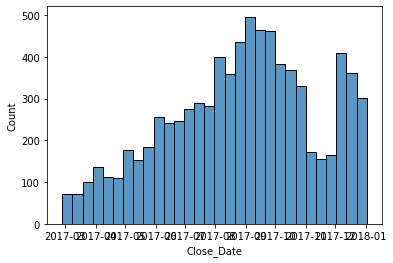

In [15]:
sns.histplot(df.Close_Date)
plt.show()

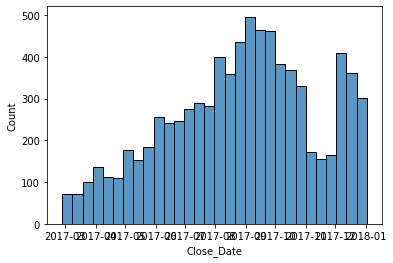

In [16]:
sns.histplot(caped_df.Close_Date)
plt.show()

In [17]:
import cape_privacy as cape

In [19]:
policy = cape.parse_policy("/content/drive/MyDrive/Utande/config/crm_data.yaml")
masked_df = cape.apply_policy(policy, df)
masked_df.head(10)

,Account,Opportunity_ID,Sales_Agent,Product,Close_Date,Close_Value,Created_On
0,ee0d64d80e,4c352f477f,Donn Cantrell,GTXBasic,2017-05-04,0.0,2017-04-22
3,0c92feefa1,815d602ca1,Niesha Huffines,GTXBasic,2017-06-26,1000.0,2017-03-18
4,0c92feefa1,e2a50ce01c,Kami Bicknell,MGRPFU,2017-08-05,5000.0,2017-05-14
5,e6337bc252,14758c22f8,Versie Hillebrand,MGRPFS,2017-05-23,0.0,2017-04-11
6,545e64fd99,9010d53bff,Kami Bicknell,GTXPlusBasic,2017-11-12,1000.0,2017-11-11
7,24a792b859,9d26945535,Kary Hendrixson,GTXBasic,2017-07-09,1000.0,2017-06-26
10,6d72e8842d,1f286fbe42,Anna Snelling,MGRPFU,2017-10-23,4000.0,2017-07-17
11,7d02fb118b,f30052b5f1,Kary Hendrixson,GTXPlusPro,2017-10-07,5000.0,2017-08-09
13,068ef9375c,03181df1df,Kary Hendrixson,GTXPro,2017-05-05,5000.0,2017-01-30
14,e308919bcf,3b58197f4d,James Ascencio,GTXPlusBasic,2017-06-24,1000.0,2017-04-26


In [20]:
caped_df.head(10)

,Account,Opportunity_ID,Sales_Agent,Product,Close_Date,Close_Value,Created_On
0,d14b92fcb4,df02ddffd3,Donn Cantrell,GTXBasic,2017-05-06,0.0,2017-04-25
3,6dc8265305,492d7e2bcd,Niesha Huffines,GTXBasic,2017-06-29,1000.0,2017-03-21
4,6dc8265305,2ba03a10c3,Kami Bicknell,MGRPFU,2017-08-05,5000.0,2017-05-12
5,70c4dbe27c,5bf1023f83,Versie Hillebrand,MGRPFS,2017-05-26,0.0,2017-04-13
6,571be6992b,976428a94c,Kami Bicknell,GTXPlusBasic,2017-11-14,1000.0,2017-11-13
7,a368f600ff,542bf555f7,Kary Hendrixson,GTXBasic,2017-07-08,1000.0,2017-06-28
10,e88aac41df,0ed25fa963,Anna Snelling,MGRPFU,2017-10-23,4000.0,2017-07-18
11,dcb5b77ec7,38d938f802,Kary Hendrixson,GTXPlusPro,2017-10-07,5000.0,2017-08-11
13,6910fd4f9c,ce7356fe13,Kary Hendrixson,GTXPro,2017-05-05,5000.0,2017-02-01
14,3e2507e04a,feac9db149,James Ascencio,GTXPlusBasic,2017-06-26,1000.0,2017-04-24
